##   Video Game industry is a fun business, but it's also full of amazing success stories. However, like film industry, it's a hit or miss in terms of investment. It's not unusual that publishers/developers invest significantly but do not receive the expected return. APB: All Points Bulletin, a game that was published on 2010 by Electronic Arts but with a dismal sales record,  cost 100 millions US dollar to develop, but eventually was sold to a different company for around 2 million US dollar.

##   There are many factors involved to determine if a game is success or not. The focus of this project, is to discover the impact from review scores along with other factors to the game sales record. The project also explore the possibility a model to predict sales from review, and a model have a predict sales from one region to another. The technique used here could be beneficial to other business. For example. with sufficient data, we can predict the sales of a Sage ERP module by review score, or predict sales across different regions.

##   Dataset for this project is from Kaggle (https://www.kaggle.com/xtyscut/video-games-sales-as-at-22-dec-2016csv?select=Video_Games_Sales_as_at_22_Dec_2016.csv). The data combines with VGSales data and review scores from Metacritic. The data is a bit old, without latest data from PS5 and Xbox Series X, but neverless, it helps to find a trend in video games sales. The data, however, is not consistent and data clean up is needed for further processing. 

In [1]:
# common imports
from pathlib import Path
import os
import numpy as np
import pandas as pd
import seaborn as sns
# sci-kit learn is our one-stop shop for machine learning!
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Data preparation

In [2]:
# read in the dataset
filepath = Path.joinpath(Path.cwd().parent, 'data', 'Video_Games_Sales_as_at_22_Dec_2016.csv')
games = pd.read_csv(filepath)

In [3]:
# data set info
games.shape

(16719, 16)

In [4]:
# what is the data look like
games.head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# unique value for each columns
games.nunique()

Name               11562
Platform              31
Year_of_Release       39
Genre                 12
Publisher            581
NA_Sales             402
EU_Sales             307
JP_Sales             244
Other_Sales          155
Global_Sales         629
Critic_Score          82
Critic_Count         106
User_Score            96
User_Count           888
Developer           1696
Rating                 8
dtype: int64

In [6]:
# how about data type
games.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

In [7]:
# check null data
games.isnull().sum().sort_values(ascending=False).head(10)

User_Count         9129
Critic_Score       8582
Critic_Count       8582
Rating             6769
User_Score         6704
Developer          6623
Year_of_Release     269
Publisher            54
Name                  2
Genre                 2
dtype: int64

# many missing data. Do the following the clean up the data
1. Drop columns that are unrelevant to this analysis ('Developer', 'User_Count', 'Critic_Count', 'Publisher', 'Name')
2. Covert Rating
3. Make datatype consistent for modeling
4. Fill nan score value with mean value for the score columns (Critic Score and User Score)
5. Drop rest of the nan value

## Drop unrelevant columns

In [8]:
games.drop(['Developer'] ,inplace =True, axis =1)
games.drop(['Critic_Count'] ,inplace =True, axis =1)
games.drop(['User_Count'] ,inplace =True, axis =1)
games.drop(['Name'], inplace=True, axis = 1)
games.drop(['Publisher'], inplace=True, axis = 1)

## Covert Rating

In [9]:
# check what type of data distribution on Rating
games['Rating'].value_counts()

E       3991
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: Rating, dtype: int64

In [10]:
# AO has only 1 game, which sales extremly too well (Grand Theft Auto 4), this will skew the analysis, let's put it into M cateogry which was its initial rating
# Also K-A (Kid to Aldut) is the same as E (everyone)
games['Rating'] = games['Rating'].replace("AO", "M")
games['Rating'] = games['Rating'].replace("K-A", "E")
games['Rating'] = games['Rating'].fillna("RP")

In [11]:
# check what's left for Rating
games['Rating'].unique()

array(['E', 'RP', 'M', 'T', 'E10+', 'EC'], dtype=object)

## Make datatype consistent

In [12]:
# check column datatype
games.dtypes

Platform            object
Year_of_Release    float64
Genre               object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
User_Score          object
Rating              object
dtype: object

While Critic_Score is float64, User_Score is an object. Convert User_Score to float64. Before that, let's check what's in User_Score first, some values might not be convertable

In [13]:
# check what User_Score could be
games['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Other than nan, 'tbd' is a non-numeric value. change 'tbd' to 'nan' as well so we can fill in some meanful value for both later on

In [14]:
# Replace'tbd' with nan
games['User_Score'] = games['User_Score'].replace('tbd', np.nan)

In [15]:
# Now change User_Score to numeric type
games['User_Score'] = games['User_Score'].astype('float64')

## Handling Nan values

In [16]:
# check null data
games.isnull().sum().sort_values(ascending=False).head(10)

User_Score         9129
Critic_Score       8582
Year_of_Release     269
Genre                 2
Platform              0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
dtype: int64

Significantn number of missing data for User_Score and Critic_Score, drop them will affect the completeness of the dataset. Fill in mean value of the column for Nan value

In [17]:
#fill in mean value for User_Score and Critic_Score
games['User_Score'].fillna(value=games['User_Score'].mean(), inplace=True)
games['Critic_Score'].fillna(value=games['Critic_Score'].mean(), inplace=True)

In [18]:
#  Still a few row missing data on Name, Genre and Year_of_Release, but not that much compared to the whole dataset. Drop them
games.dropna(inplace=True)

In [19]:
#check null again, data is clean
games.isnull().sum().sort_values(ascending=False).head(10)

Platform           0
Year_of_Release    0
Genre              0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Critic_Score       0
User_Score         0
dtype: int64

In [20]:
# how many record left after the cleanup
games.shape

(16448, 11)

## Analyze

<AxesSubplot:>

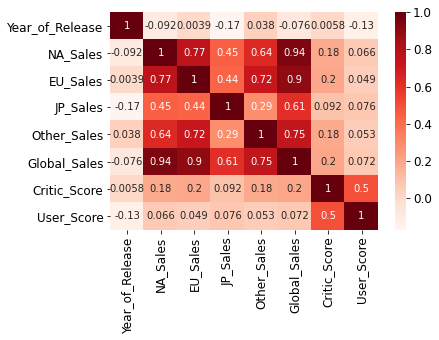

In [21]:
# check correlation between features
sns.heatmap(games.corr(),annot=True,cmap='Reds', fmt='.2g')

From the heat map, these have strong correlations
- NA_SALES and EU_SALES
- NA_SALES and Other_SALES
- Global Sales and all other type of Sales (this makes sense as Global Sales are the total of others). No need to further model this
- Critic_Score and Global Sales (not very strong, but let's still build a model based on that to predict sales
User_Score doesn't seem to have too much correlation with sales

[(0.0, 17.5)]

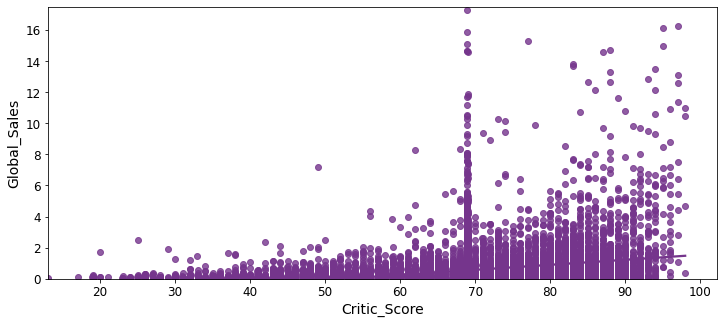

In [22]:
# Visualize the correlation between Critic_Score and Global_Sales
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=games, ci=None, color="#75358c", x_jitter=.02).set(ylim=(0, 17.5))

[(0.0, 17.5)]

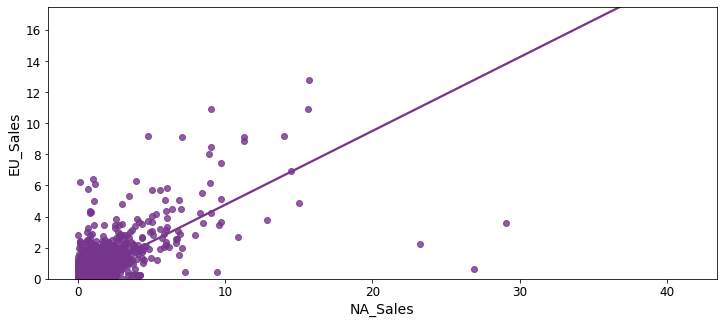

In [23]:
# Visualize the correlation between North American Sales and Europe Sales
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="NA_Sales", y="EU_Sales", data=games, ci=None, color="#75358c", x_jitter=.02).set(ylim=(0, 17.5))

## First to analyze factors to affect global sales

In [24]:
# Convert categorical variable into dummy/indicator variables.
games_full = pd.get_dummies(games)

In [25]:
# what it looks like now
games_full.head()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Platform_2600,Platform_3DO,...,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Rating_E,Rating_E10+,Rating_EC,Rating_M,Rating_RP,Rating_T
0,2006.0,41.36,28.96,3.77,8.45,82.53,76.000000,8.000000,0,0,...,0,0,1,0,1,0,0,0,0,0
1,1985.0,29.08,3.58,6.81,0.77,40.24,68.967679,7.125046,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2008.0,15.68,12.76,3.79,3.29,35.52,82.000000,8.300000,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2009.0,15.61,10.93,3.28,2.95,32.77,80.000000,8.000000,0,0,...,0,0,1,0,1,0,0,0,0,0
4,1996.0,11.27,8.89,10.22,1.00,31.37,68.967679,7.125046,0,0,...,0,0,0,0,0,0,0,0,1,0


Train-Test split for linear regression

In [26]:
# Predict Global_Sales from Genre, Rating, Platform, User_Score and Critic_Score 
y = games["Global_Sales"].copy()
X = games_full.drop(['Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales'], axis = 1)

In [27]:
# Now, split both X and y data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=0.2, 
                                       random_state=42)

In [28]:
# Create a local instance of the sklearn class
lin_reg = LinearRegression()

In [29]:
# Fit your instance to the training dataset
lin_reg.fit(X_train, y_train)

LinearRegression()

In [30]:
lin_reg_score_train = lin_reg.score(X_test, y_test)
lin_reg_score_test = lin_reg.score (X_train, y_train)
print("Training score: ",lin_reg_score_train)
print("Testing score: ",lin_reg_score_test)

Training score:  0.04847606045569386
Testing score:  0.13088303066649187


In [31]:
# Make predictions on the testing dataset
y_preds = lin_reg.predict(X_test)

In [32]:
# Evaluation
print('mae', mean_absolute_error(y_test, y_preds))
print('rmse', np.sqrt(mean_squared_error(y_test, y_preds)))
print('R2', r2_score(y_test, y_preds))

mae 0.5864696883743017
rmse 2.002829955806433
R2 0.04847606045569386


In [33]:
# Print the coefficients and Intercept
print(lin_reg.intercept_)
print(lin_reg.coef_)

106.01515362882233
[-5.36038448e-02  3.75166085e-02 -8.00278300e-02 -8.38067730e-01
 -7.63213573e-01  4.76428219e-01 -5.25386841e-01  1.40705967e-01
  1.98565465e+00 -2.15058698e-01 -3.00998205e-01  9.74286420e-02
  7.24420524e-15 -3.67787039e-02  1.14997790e+00 -8.14854510e-01
 -3.04798430e-01 -1.33226763e-15 -1.48174003e-01  6.23522631e-02
  3.98085503e-01  6.67889096e-01  2.24756849e-02  1.66198641e-01
 -5.98191492e-01 -5.49847065e-01 -7.27720484e-02 -7.72790953e-01
 -3.77674416e-01  3.71105201e-01  3.58972164e-01  3.99147462e-01
 -3.80162581e-01  4.02347857e-01  5.26675361e-02 -1.61098183e-01
  3.97291344e-02 -3.68312928e-02  3.65054018e-01 -1.56232831e-01
  6.25469259e-02  6.13893486e-02  9.63375948e-02 -2.81716554e-03
 -1.27799657e-01 -1.92945429e-01  5.67357899e-02 -5.81575348e-02
 -9.96244080e-02  3.30971492e-01 -2.07543351e-01 -2.23819884e-02]


In [34]:
# coefficient checking and visualization
feature_imp = pd.DataFrame(zip(X.columns, lin_reg.coef_), columns = ['features', 'coeffs'])
feature_imp=feature_imp.set_index('features')
feature_imp=feature_imp.sort_values('coeffs')

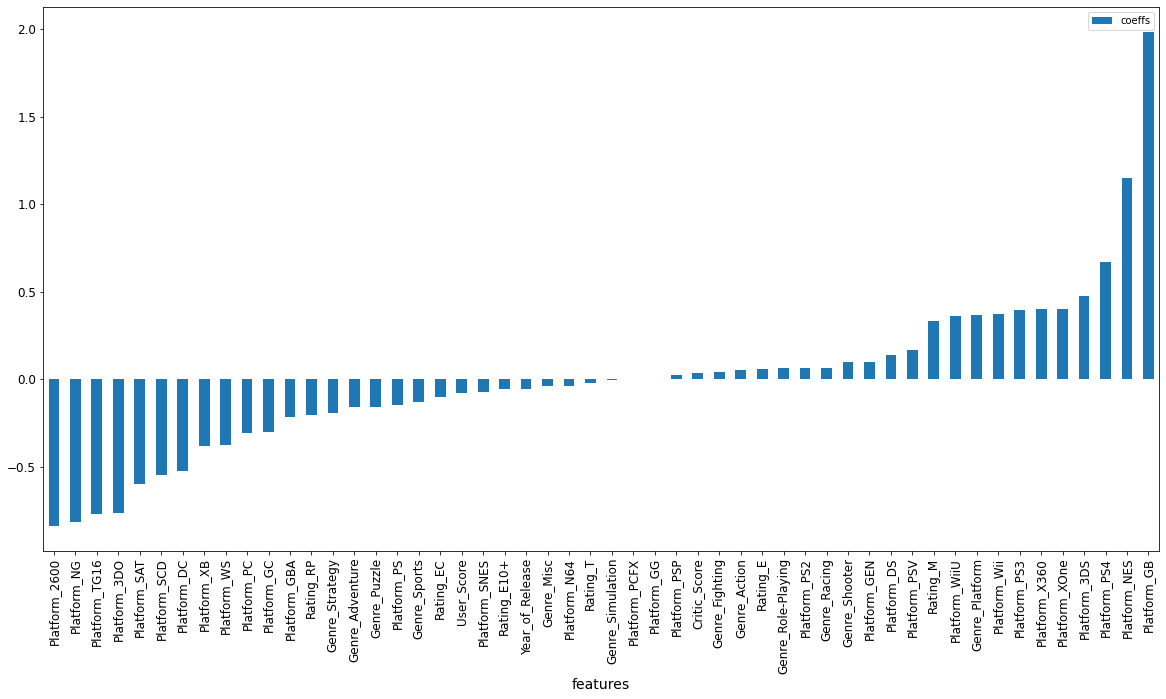

In [35]:
# plot that as a bar chart
feature_imp.plot(kind='bar', figsize=(20,10));

## Findings
- Platform is the dominant factor to affect global sales. Nintendo consoles and current generation (PS4 and Xbox one for this data set) generally have positive impact, yet PC games doesn't sell as good as console games
- Mature Rating games, in generall, Sales is decent
- In term of Genre, Shooter is the best among all Genres
- Review Scores (both Critic and User score) do not seem to have strong impact to global sales

In [36]:
games

,Platform,Year_of_Release,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating
0,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,82.53,76.000000,8.000000,E
1,NES,1985.0,Platform,29.08,3.58,6.81,0.77,40.24,68.967679,7.125046,RP
2,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,35.52,82.000000,8.300000,E
3,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,32.77,80.000000,8.000000,E
4,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,31.37,68.967679,7.125046,RP
...,...,...,...,...,...,...,...,...,...,...,...
16714,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.01,68.967679,7.125046,RP
16715,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.01,68.967679,7.125046,RP
16716,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,0.01,68.967679,7.125046,RP
16717,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.01,68.967679,7.125046,RP


In [37]:
# Transform categorized variable ('Genre')
games['Genre'], label_genre = pd.factorize(games['Genre'])
games['Platform'], label_platform = pd.factorize(games['Platform'])

In [38]:
# check numerized genre labels
label_genre

Index(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure', 'Strategy'],
      dtype='object')

In [39]:
# check numberized platform labels
label_platform

Index(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA', 'PS4',
       '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'WiiU', 'GC',
       'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16', '3DO', 'GG',
       'PCFX'],
      dtype='object')

Now a model to predict Europe Sales from North American Sales

In [40]:
y_sales = games["EU_Sales"].copy()
X_sales = games.drop(['Global_Sales','JP_Sales', 'EU_Sales', 'Other_Sales', 'Year_of_Release', 'User_Score', 'Critic_Score', 'Rating'], axis = 1)

In [41]:
# Now, split both X and y data into training and testing sets.
X_sales_train, X_sales_test, y_sales_train, y_sales_test = train_test_split(X_sales, y_sales, 
                                       test_size=0.2, 
                                       random_state=42)

# Create a local instance of the sklearn class
lin_reg_sales = LinearRegression()

# Fit your instance to the training dataset
lin_reg_sales.fit(X_sales_train, y_sales_train)



LinearRegression()

In [42]:
# Print the coefficients.
print(lin_reg_sales.intercept_)
print(lin_reg_sales.coef_)

0.051137792717953254
[-0.0008035  -0.00118762  0.40559451]


In [43]:
# Eu_Sales evaluation
lin_reg_sales_score_train = lin_reg_sales.score(X_sales_test, y_sales_test)
lin_reg_sales_score_test = lin_reg_sales.score (X_sales_train, y_sales_train)

print("Training score: ",lin_reg_sales_score_train)
print("Testing score: ",lin_reg_sales_score_test)

# Make predictions on the testing dataset
y_sales_preds = lin_reg_sales.predict(X_sales_test)

# Evaluation. What do these mean?
print('mae', mean_absolute_error(y_sales_test, y_sales_preds))
print('rmse', np.sqrt(mean_squared_error(y_sales_test, y_sales_preds)))
print('R2', r2_score(y_sales_test, y_sales_preds))

Training score:  0.7251607603384504
Testing score:  0.48185634208965855
mae 0.11223120880164543
rmse 0.3681048431142222
R2 0.7251607603384504


In [44]:
# try some other data
# predict EU sales from 11.5 million NA sales on a sport Wii game
# predict EU sales from 3 million NA sales on a sport Wii game
m = lin_reg_sales.predict([[0, 0, 11.55],[0,1,11.55],[1, 0, 11.55]])
m

array([4.73575434, 4.73456673, 4.73495085])

In [46]:
# try KNN
from sklearn import neighbors
n_neighbors=5
knn_reg=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn_reg.fit(X_sales_train, y_sales_train)

KNeighborsRegressor()

In [47]:
knn_score_train = knn_reg.score(X_sales_test, y_sales_test)
knn_score_test = knn_reg.score(X_sales_train, y_sales_train)

print("Training score: ",knn_score_train)
print("Testing score: ",knn_score_test)

Training score:  0.502031432418089
Testing score:  0.7160476879511554


In [48]:
# Make predictions on the testing dataset
y_preds = knn_reg.predict(X_sales_test)

In [ ]:
m = knn_reg.predict([[30],[80],[90]])

In [ ]:
m

In [ ]:
y_preds

In [ ]:
# Evaluation. What do these mean?
print('mae', mean_absolute_error(y_test, y_preds))
print('rmse', np.sqrt(mean_squared_error(y_test, y_preds)))
print('R2', r2_score(y_test, y_preds))